In [230]:
import copulas
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf
from pathlib import Path
from datetime import date
from hmmlearn.hmm import GaussianHMM
import seaborn as sns
from scipy.stats import rankdata
from copulas.multivariate import GaussianMultivariate
from copulas.visualization import compare_3d



Crear cartera equiponderada (sin rebalanceos) compuesta por: 
AAPL, AMZN, BAC, BRK-B, CVX, ENPH, GLD, GME, GOOGL, JNJ, JPM, MSFT, NVDA, PG, XOM, bono del gobierno americano a 10 años, bono del gobierno americano a 2 años y HYG (BAMLH0A0HYM2). 

Fase 1: Detectando el 'Pulso' del Mercado (Hidden Markov Models) 
Objetivo: Considerando la existencia de dos estados de mercado (calma y crisis), identifica, 
para cada día, en qué estado se encuentra el mercado. 
• Tarea  Técnica:  Ajustar  un  modelo  Gaussian  HMM  (Hidden  Markov  Model)  de  2 
estados sobre la serie de retornos multivariante y/o sobre factores representativos. 
• Output Visual: Gráfico del S&P 500 coloreado según el régimen detectado (Blanco = 
Calma, Azul = Crisis).

In [161]:
import sys
print(sys.executable)

c:\Users\Natalia\workplace\Practica-MIAX-gestion-de-riesgos\.venv\Scripts\python.exe


In [162]:
date_init = '2005-12-01'
symbols = ['AAPL','AMZN','BAC','BRK-B','CVX','ENPH','GLD','GME','GOOGL','JNJ','JPM','MSFT','NVDA','PG','XOM']
bons = ['DGS10', 'DGS2']
hyg = 'BAMLH0A0HYM2'

In [163]:
# descargar precios ajustados desde Yahoo hasta hoy
end = pd.Timestamp.today().normalize()
sp500 = yf.download('^GSPC', start=date_init, end=end, auto_adjust=True, progress=False)

if isinstance(sp500.columns, pd.MultiIndex):
     sp500.columns = sp500.columns.get_level_values(0)

sp500.index.name = None

# normalizar columnas
sp500 = sp500.rename(columns=str.lower).reset_index()
sp500 = sp500.rename(columns={'index': 'date'})
# calcular retornos
sp500['ret_close'] = sp500['close'].pct_change().dropna()

# quedarnos solo con las 3 columnas deseadas
returns = sp500[['date', 'ret_close']].dropna().copy()

returns.head()




Price,date,ret_close
1,2005-12-02,0.000324
2,2005-12-05,-0.002363
3,2005-12-06,0.001276
4,2005-12-07,-0.005009
5,2005-12-08,-0.001217


El ratio de Amihud captura cuánto se mueve el precio por unidad de volumen negociado:
Amihud_t = |R_t| / Volumen_t
- Si el precio cambia mucho con poco volumen → mercado ilíquido → Amihud alto
- Si el precio cambia poco con mucho volumen → mercado líquido → Amihud bajo
SPY es uno de los activos más líquidos del mundo, así que sus valores de Amihud son extremadamente bajos.

USAR COMO FEATURE DE LIQUIDEZ EM HMM

In [164]:
spy = yf.download('SPY', start=date_init, end=end, auto_adjust=True, progress=False)
spy = spy.rename(columns=str.lower)
spy.index.name = 'date'

spy_ret = spy['close'].pct_change().dropna()

spy_vol = spy['volume']

amihud_spy = (spy_ret['spy'].abs() / spy_vol['spy']).to_frame(name='amihud_sp500')
amihud_spy = amihud_spy.reset_index() 
amihud_spy.head()

,date,amihud_sp500
0,2005-12-01,NaN
1,2005-12-02,2.704808e-11
2,2005-12-05,3.591405e-11
3,2005-12-06,3.272982e-11
4,2005-12-07,8.733442e-11


In [165]:
BASE_URL = 'https://fred.stlouisfed.org/graph/fredgraph.csv?id='

def download_fred(serie):
    '''
    Descarga cualquier serie de FRED usando solo pandas.
    serie: código de la serie en FRED (ej: 'DGS10', 'DGS2', 'VIXCLS')
    '''
    url = BASE_URL + serie
    df = pd.read_csv(url)

    # FRED usa 'observation_date' como nombre de columna cambio por 'date' y convertir a datetime
    df.rename(columns={'observation_date': 'date'}, inplace=True)
    df['date'] = pd.to_datetime(df['date'])

    # Filtrar por fecha de inicio date_init
    df = df[df['date'] >= pd.to_datetime(date_init)]


    # Calcular cambio diario
    df[f'{serie}_change'] = df[serie].diff()

    return df


In [166]:
vixcls = download_fred('VIXCLS')
vixcls.head()


,date,VIXCLS,VIXCLS_change
4152,2005-12-01,11.24,NaN
4153,2005-12-02,11.01,-0.23
4154,2005-12-05,11.60,0.59
4155,2005-12-06,11.52,-0.08
4156,2005-12-07,12.18,0.66


In [167]:
dgs10 = download_fred('DGS10')
dgs10.head()

,date,DGS10,DGS10_change
11457,2005-12-01,4.52,NaN
11458,2005-12-02,4.52,0.00
11459,2005-12-05,4.57,0.05
11460,2005-12-06,4.49,-0.08
11461,2005-12-07,4.52,0.03


In [168]:
dgs2 = download_fred('DGS2')
dgs2.head()

,date,DGS2,DGS2_change
7697,2005-12-01,4.45,NaN
7698,2005-12-02,4.43,-0.02
7699,2005-12-05,4.47,0.04
7700,2005-12-06,4.42,-0.05
7701,2005-12-07,4.42,0.00


In [169]:
hy_oas = download_fred('BAMLH0A0HYM2')
hy_oas.head()

,date,BAMLH0A0HYM2,BAMLH0A0HYM2_change
2357,2005-12-01,3.62,NaN
2358,2005-12-02,3.63,0.01
2359,2005-12-05,3.62,-0.01
2360,2005-12-06,3.68,0.06
2361,2005-12-07,3.66,-0.02


Uso Chicago PMI com proxy porque no esta disponible PMI desde 2003. 
CFNAI =  Chicago Fed National Activity Index. 
Es un idice de 85 indicadores económocos de EEUU. Su objetivo es medir si la economía está por encima de la tendencia histórica o por debajo. Si su valor es menor a  -0.7 es una clara señal de recesión. La versión MA3, es la media movila a 3 meses, se usa en análisis macro porque es más estable y menos ruidosa. 

In [170]:
pmi = download_fred('CFNAIMA3')
pmi_daily = (
    pmi
    .set_index("date")
    .resample("D")
    .ffill()
    .reset_index()
)

pmi_daily.head() #Todos los datos de diceimbre 2005 salen a NaN, pero los datos de enero 2006 ya están completos, por lo que no hay problema.

,date,CFNAIMA3,CFNAIMA3_change
0,2005-12-01,0.57,NaN
1,2005-12-02,0.57,NaN
2,2005-12-03,0.57,NaN
3,2005-12-04,0.57,NaN
4,2005-12-05,0.57,NaN


CPI es una medida mensual, indica los indice de precios de consumo, la pérdida o ganancia de poder adquisitivo de los hogares

cpi_daily = cpi.set_index("date").resample("D").ffill().reset_index()


In [171]:
cpi = download_fred('CPIAUCSL')
cpi_daily = (
    cpi
    .set_index("date")
    .resample("D")
    .ffill()
    .reset_index()
)

cpi_daily.head() #Todos los datos de diciembre 2005 salen a NaN, pero los datos de enero 2006 ya están completos, por lo que no hay problema.


,date,CPIAUCSL,CPIAUCSL_change
0,2005-12-01,198.1,NaN
1,2005-12-02,198.1,NaN
2,2005-12-03,198.1,NaN
3,2005-12-04,198.1,NaN
4,2005-12-05,198.1,NaN


In [172]:
unrate = download_fred('UNRATE')

unrate_daily = (
    unrate
    .set_index("date")
    .resample("D")
    .ffill()
    .reset_index()
)

unrate_daily.head() #Todos los datos de diceimbre 2005 salen a NaN, pero los datos de enero 2006 ya están completos, por lo que no hay problema.

,date,UNRATE,UNRATE_change
0,2005-12-01,4.9,NaN
1,2005-12-02,4.9,NaN
2,2005-12-03,4.9,NaN
3,2005-12-04,4.9,NaN
4,2005-12-05,4.9,NaN


El Put/Call Ratio mide el volumen relativo de opciones put frente a opciones call.
Es uno de los indicadores de sentimiento más usados:
- Mayor que 1.0 → sentimiento bajista (más puts que calls)
- Menos que 0.7 → sentimiento alcista (más calls que puts)
- Entre 0.7 y 1.0 → neutral


In [173]:
df_final = (
    returns
    .merge(sp500[['date', 'close']], on='date', how='left')
    .merge(amihud_spy[['date', 'amihud_sp500']], on='date', how='left')
    .merge(vixcls[['date', 'VIXCLS_change']], on='date', how='left')
    .merge(dgs10[['date', 'DGS10_change']], on='date', how='left')
    .merge(dgs2[['date', 'DGS2_change']], on='date', how='left')
    .merge(hy_oas[['date', 'BAMLH0A0HYM2_change']], on='date', how='left')
    .merge(pmi_daily[['date', 'CFNAIMA3_change']], on='date', how='left')
    .merge(cpi_daily[['date', 'CPIAUCSL_change']], on='date', how='left')
    .merge(unrate_daily[['date', 'UNRATE_change']], on='date', how='left')
)
df_final = df_final[df_final['date'] >= '2006-01-01']
df_final.head(500)


,date,ret_close,close,amihud_sp500,VIXCLS_change,DGS10_change,DGS2_change,BAMLH0A0HYM2_change,CFNAIMA3_change,CPIAUCSL_change,UNRATE_change
20,2006-01-03,0.016430,1268.800049,2.401001e-10,NaN,NaN,NaN,NaN,-0.05,1.200,-0.2
21,2006-01-04,0.003673,1273.459961,9.124398e-11,0.23,-0.01,-0.03,-0.04,-0.05,1.200,-0.2
22,2006-01-05,0.000016,1273.479980,1.329049e-11,-0.06,0.00,0.01,-0.05,-0.05,1.200,-0.2
23,2006-01-06,0.009399,1285.449951,1.323275e-10,-0.31,0.02,0.04,-0.08,-0.05,1.200,-0.2
24,2006-01-09,0.003656,1290.150024,5.902931e-11,0.13,0.00,0.00,-0.05,-0.05,1.200,-0.2
...,...,...,...,...,...,...,...,...,...,...,...
515,2007-12-20,0.004900,1460.119995,2.936033e-11,-1.10,-0.02,-0.03,0.08,-0.13,0.611,0.3
516,2007-12-21,0.016670,1484.459961,9.867561e-11,-2.11,0.14,0.10,-0.11,-0.13,0.611,0.3
517,2007-12-24,0.008077,1496.449951,1.628508e-10,0.13,0.05,0.05,-0.03,-0.13,0.611,0.3
518,2007-12-26,0.000809,1497.660034,3.196105e-11,NaN,NaN,NaN,NaN,-0.13,0.611,0.3


Con los datos obtenidos se procede a aplicar el modelo modelo  Gaussian  HMM. 

In [174]:
features = [
    'ret_close',
    'amihud_sp500',
    'VIXCLS_change',
    'DGS10_change',
    'DGS2_change',
    'BAMLH0A0HYM2_change',
    'CFNAIMA3_change',
    'CPIAUCSL_change',
    'UNRATE_change'
]
df_final = df_final.sort_values("date").set_index("date")

df_final = df_final.bfill() #sustituye los valores faltantes anteriores
df_final = df_final.ffill() #sustituye los valores faltantes posteriores

df_final = df_final.reset_index()

df_to_HMM = df_final[features].values

In [175]:
model = GaussianHMM(
    n_components=2,        # número de regímenes
    covariance_type='full',
    n_iter=500,
    random_state=42
)

model.fit(df_to_HMM)


,n_components,2
,covariance_type,'full'
,min_covar,0.001
,startprob_prior,1.0
,transmat_prior,1.0
,means_prior,0
,means_weight,0
,covars_prior,0.01
,covars_weight,1
,algorithm,'viterbi'
,random_state,42


In [176]:
df_final["regime"] = model.predict(df_to_HMM)

In [177]:
stats = df_final.groupby("regime")["ret_close"].agg(["mean", "std"])

stats["sharpe"] = stats["mean"] / stats["std"]
crisis_state = stats["sharpe"].idxmin()
calm_state   = stats["sharpe"].idxmax()
print(f"Crisis es {crisis_state}, Calma es {calm_state}")
print(f"Numero de días por estado: {df_final['regime'].value_counts()}")

Crisis es 1, Calma es 0
Numero de días por estado: regime
0    4410
1     646
Name: count, dtype: int64


In [178]:
df_final["regime_shift"] = df_final["regime"].diff().fillna(0).abs()
num_shifts = df_final["regime_shift"].sum()

print("Número de cambios de estado:", int(num_shifts))


Número de cambios de estado: 110


In [179]:
df_final["regime_run"] = (df_final["regime"] != df_final["regime"].shift()).cumsum() #contador para cambios de régimen
durations = df_final.groupby(["regime", "regime_run"]).size() #duración de cada período de régimen

durations



regime  regime_run
0       1             288
        3             180
        5               6
        7              38
        9              33
                     ... 
1       102             3
        104             3
        106             6
        108             1
        110             1
Length: 111, dtype: int64

In [180]:
durations.groupby(level=0).mean() #duración media de cada régimen


regime
0    78.750000
1    11.745455
dtype: float64

In [181]:
crisis_durations = durations.loc[crisis_state]
valid_crisis_runs = crisis_durations[crisis_durations > 3].index # MAYOR A  LO HE PUESTO SIN CRTITERIO; PARA ELIMINAR EPISODIOS MUY CORTOS QUE NO PARECEN CRISIS REALES


In [182]:
calm_durations = durations.loc[calm_state]
valid_calm_runs = calm_durations[calm_durations > 3].index
valid_calm_runs

Index([  1,   3,   5,   7,   9,  11,  13,  15,  17,  19,  21,  23,  25,  29,
        31,  33,  35,  37,  39,  41,  43,  45,  47,  49,  51,  53,  55,  57,
        59,  65,  67,  69,  71,  73,  75,  77,  79,  81,  85,  87,  89,  91,
        93,  95,  97,  99, 101, 103, 105, 111],
      dtype='int64', name='regime_run')

In [183]:
crisis_periods = []
current_start = None
current_run = None

for i in range(len(df_final)):
    regime = df_final["regime"].iloc[i]
    run_id = df_final["regime_run"].iloc[i]
    date = df_final["date"].iloc[i]

    if regime == crisis_state and run_id in valid_crisis_runs:
        if current_start is None:
            current_start = date
            current_run = run_id
    elif regime == calm_state and run_id in valid_calm_runs:
        if current_start is not None:
            crisis_periods.append((current_start, date))
            current_start = None
            current_run = None

# Si termina dentro de un periodo válido
if current_start is not None:
    crisis_periods.append((current_start, df_final["date"].iloc[-1]))


for start, end in crisis_periods:
    print(start, "→", end)

print(f"Número de períodos de crisis(>3 días): {len(crisis_periods)}")


2008-09-02 00:00:00 → 2009-05-08 00:00:00
2009-05-20 00:00:00 → 2009-08-04 00:00:00
2010-05-20 00:00:00 → 2010-06-03 00:00:00
2011-08-04 00:00:00 → 2011-08-12 00:00:00
2015-08-21 00:00:00 → 2015-08-27 00:00:00
2018-02-05 00:00:00 → 2018-02-12 00:00:00
2020-02-27 00:00:00 → 2020-11-10 00:00:00
2021-01-27 00:00:00 → 2021-04-01 00:00:00
2021-05-03 00:00:00 → 2021-07-01 00:00:00
2021-11-26 00:00:00 → 2021-12-02 00:00:00
2022-02-24 00:00:00 → 2022-03-22 00:00:00
2022-05-02 00:00:00 → 2022-07-01 00:00:00
2023-03-10 00:00:00 → 2023-03-20 00:00:00
2025-04-03 00:00:00 → 2025-04-22 00:00:00
Número de períodos de crisis(>3 días): 14


In [184]:
calm_periods = []

# Calma antes de la primera crisis
start_calm = df_final["date"].min()
end_calm = crisis_periods[0][0] - pd.Timedelta(days=1)
calm_periods.append((start_calm, end_calm))

# Calmas intermedias
for i in range(len(crisis_periods)-1):
    start_calm = crisis_periods[i][1] + pd.Timedelta(days=1)
    end_calm = crisis_periods[i+1][0] - pd.Timedelta(days=1)
    calm_periods.append((start_calm, end_calm))

# Calma después de la última crisis
start_calm = crisis_periods[-1][1] + pd.Timedelta(days=1)
end_calm = df_final["date"].max()
calm_periods.append((start_calm, end_calm))

calm_periods

[(Timestamp('2006-01-03 00:00:00'), Timestamp('2008-09-01 00:00:00')),
 (Timestamp('2009-05-09 00:00:00'), Timestamp('2009-05-19 00:00:00')),
 (Timestamp('2009-08-05 00:00:00'), Timestamp('2010-05-19 00:00:00')),
 (Timestamp('2010-06-04 00:00:00'), Timestamp('2011-08-03 00:00:00')),
 (Timestamp('2011-08-13 00:00:00'), Timestamp('2015-08-20 00:00:00')),
 (Timestamp('2015-08-28 00:00:00'), Timestamp('2018-02-04 00:00:00')),
 (Timestamp('2018-02-13 00:00:00'), Timestamp('2020-02-26 00:00:00')),
 (Timestamp('2020-11-11 00:00:00'), Timestamp('2021-01-26 00:00:00')),
 (Timestamp('2021-04-02 00:00:00'), Timestamp('2021-05-02 00:00:00')),
 (Timestamp('2021-07-02 00:00:00'), Timestamp('2021-11-25 00:00:00')),
 (Timestamp('2021-12-03 00:00:00'), Timestamp('2022-02-23 00:00:00')),
 (Timestamp('2022-03-23 00:00:00'), Timestamp('2022-05-01 00:00:00')),
 (Timestamp('2022-07-02 00:00:00'), Timestamp('2023-03-09 00:00:00')),
 (Timestamp('2023-03-21 00:00:00'), Timestamp('2025-04-02 00:00:00')),
 (Time

In [185]:
rows = []

# crisis
for i, (start, end) in enumerate(crisis_periods, start=1):
    mask = (df_final["date"] >= start) & (df_final["date"] <= end)
    for d in df_final.loc[mask, "date"]:
        rows.append({"date": d, "period_id": i, "period_type": "crisis"})

# calma
for i, (start, end) in enumerate(calm_periods, start=1):
    mask = (df_final["date"] >= start) & (df_final["date"] <= end)
    for d in df_final.loc[mask, "date"]:
        rows.append({"date": d, "period_id": i, "period_type": "calm"})


df_periods = pd.DataFrame(rows)
df_periods = df_periods.sort_values("date").reset_index(drop=True)
df_periods.head(500)

,date,period_id,period_type
0,2006-01-03,1,calm
1,2006-01-04,1,calm
2,2006-01-05,1,calm
3,2006-01-06,1,calm
4,2006-01-09,1,calm
...,...,...,...
495,2007-12-20,1,calm
496,2007-12-21,1,calm
497,2007-12-24,1,calm
498,2007-12-26,1,calm


In [186]:
period_info = []

# crisis
for i, (start, end) in enumerate(crisis_periods, start=1):
    period_info.append({"period_type": "crisis", "period_id": i, "start_date": start})

# calma
for i, (start, end) in enumerate(calm_periods, start=1):
    period_info.append({"period_type": "calm", "period_id": i, "start_date": start})

df_period_info = pd.DataFrame(period_info)


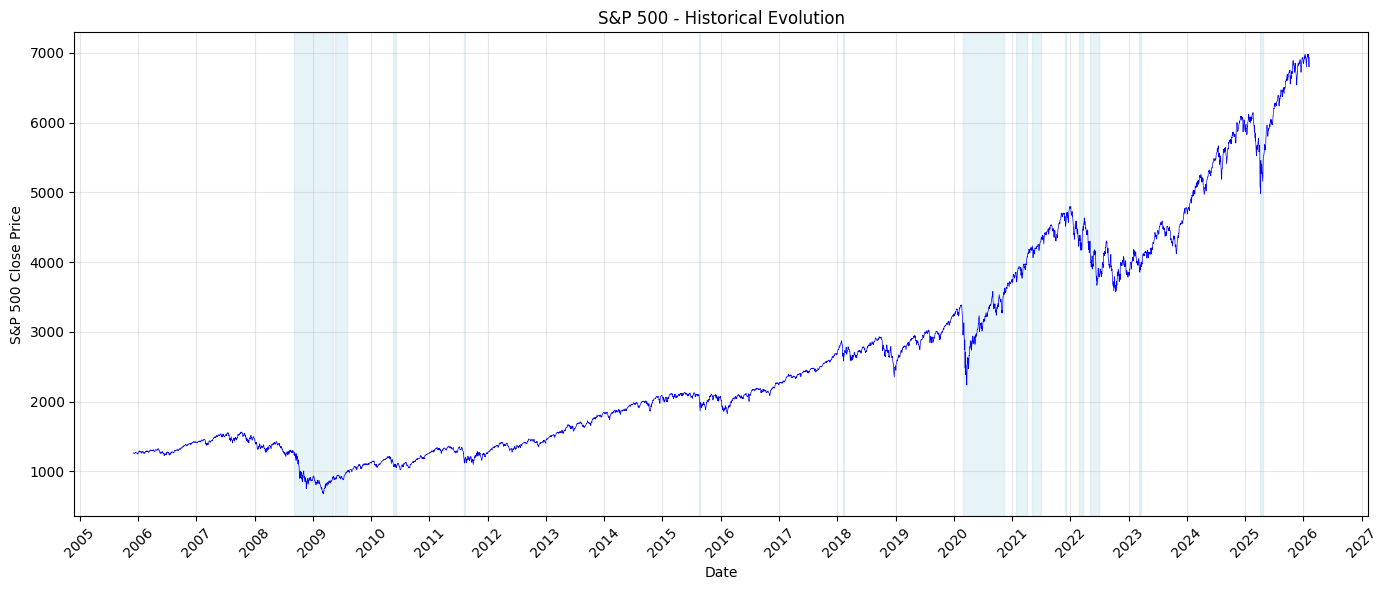

In [199]:
plt.figure(figsize=(14, 6))
plt.plot(sp500['date'], sp500['close'], linewidth=0.5, color='blue')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.title('S&P 500 - Historical Evolution')
plt.grid(True, alpha=0.3)

for start, end in crisis_periods:
    plt.axvspan(start, end, color='lightblue', alpha=0.3)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(1))         
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))    

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Fase 2: Anatomía del Riesgo (Análisis Marginal)

In [188]:
# Retornos diarios de la lista de symbols desde diciembre 2005 hasta hoy
df_symbols = yf.download(symbols, start='2006-01-01', end=end, auto_adjust=True)[["Close"]]

df_symbols = df_symbols.reset_index()
df_symbols = df_symbols.rename(columns={"Date": "date"})
df_symbols["date"] = pd.to_datetime(df_symbols["date"])

if isinstance(df_symbols.columns, pd.MultiIndex):
    new_cols = ["date"] + [col[1] for col in df_symbols.columns[1:]]
    df_symbols.columns = new_cols

df_symbols = df_symbols.sort_values("date").reset_index(drop=True)
df_returns_symbols = df_symbols.copy()
for s in symbols:
    df_returns_symbols[s] = df_symbols[s].pct_change()  
df_returns_symbols.head(5000)

[*********************100%***********************]  15 of 15 completed


,date,AAPL,AMZN,BAC,BRK-B,CVX,ENPH,GLD,GME,GOOGL,JNJ,JPM,MSFT,NVDA,PG,XOM
0,2006-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006-01-04,0.002943,-0.006936,-0.010620,0.000675,-0.002878,NaN,0.003389,0.035283,0.022999,0.015415,-0.005771,0.004844,0.027997,0.001872,0.001711
2,2006-01-05,-0.007870,0.008466,0.001288,-0.002359,-0.012222,NaN,-0.018011,0.115396,0.013476,-0.004155,0.003029,0.000741,0.022650,-0.003227,-0.004952
3,2006-01-06,0.025813,0.004617,-0.001501,0.003378,0.018216,NaN,0.026366,0.032431,0.031956,0.004493,0.007045,-0.002964,0.016427,-0.001022,0.019732
4,2006-01-09,-0.003277,-0.016503,0.000644,0.003030,-0.005063,NaN,0.016381,-0.004933,0.002663,0.006230,0.016242,-0.001858,0.027914,0.007503,-0.000504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4850,2025-04-14,0.022054,-0.014875,0.020028,0.010322,-0.002285,0.051262,-0.005706,0.021970,0.012282,0.017333,-0.006266,-0.001648,-0.001983,0.013300,0.002424
4851,2025-04-15,-0.001876,-0.013892,0.035997,-0.002550,-0.005764,-0.027131,0.005232,-0.010378,-0.017351,-0.004794,-0.006774,-0.005363,0.013459,-0.003902,-0.002805
4852,2025-04-16,-0.038933,-0.029289,-0.017373,-0.022190,0.006095,-0.024873,0.032541,-0.016854,-0.019065,0.001888,-0.015099,-0.036606,-0.068717,-0.012346,0.010572
4853,2025-04-17,0.013950,-0.009866,0.002143,0.003408,0.018543,0.015266,-0.004391,0.020191,-0.014152,0.023130,0.010235,-0.010306,-0.028711,0.025482,0.026202


In [189]:
df_aut_risk = (
df_returns_symbols
    .merge(dgs10[['date', 'DGS10_change']], on='date', how='left')
    .merge(dgs2[['date', 'DGS2_change']], on='date', how='left')
    .merge(hy_oas[['date', 'BAMLH0A0HYM2_change']], on='date', how='left')
)
df_auto = df_aut_risk[df_aut_risk['date'] >= '2006-01-01']
df_auto.head(500)

,date,AAPL,AMZN,BAC,BRK-B,CVX,ENPH,GLD,GME,GOOGL,JNJ,JPM,MSFT,NVDA,PG,XOM,DGS10_change,DGS2_change,BAMLH0A0HYM2_change
0,2006-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006-01-04,0.002943,-0.006936,-0.010620,0.000675,-0.002878,NaN,0.003389,0.035283,0.022999,0.015415,-0.005771,0.004844,0.027997,0.001872,0.001711,-0.01,-0.03,-0.04
2,2006-01-05,-0.007870,0.008466,0.001288,-0.002359,-0.012222,NaN,-0.018011,0.115396,0.013476,-0.004155,0.003029,0.000741,0.022650,-0.003227,-0.004952,0.00,0.01,-0.05
3,2006-01-06,0.025813,0.004617,-0.001501,0.003378,0.018216,NaN,0.026366,0.032431,0.031956,0.004493,0.007045,-0.002964,0.016427,-0.001022,0.019732,0.02,0.04,-0.08
4,2006-01-09,-0.003277,-0.016503,0.000644,0.003030,-0.005063,NaN,0.016381,-0.004933,0.002663,0.006230,0.016242,-0.001858,0.027914,0.007503,-0.000504,0.00,0.00,-0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2007-12-20,0.022335,0.013426,-0.004328,-0.008263,0.012651,NaN,-0.007193,0.018534,0.018188,0.000149,-0.014779,0.020983,0.020900,0.002877,0.007656,-0.02,-0.03,0.08
496,2007-12-21,0.035789,0.007507,0.012316,0.007656,0.021619,NaN,0.018177,-0.010467,0.010150,0.010396,0.018001,0.015203,-0.000284,0.012161,0.014111,0.14,0.10,-0.11
497,2007-12-24,0.025218,-0.002739,0.008588,0.014525,0.004679,NaN,0.000499,0.030106,0.005799,-0.002352,0.016323,0.014420,0.017634,-0.001890,0.002462,0.05,0.05,-0.03
498,2007-12-26,0.000755,0.020218,0.000473,0.006608,0.003810,NaN,0.017220,-0.006635,0.014428,-0.004568,0.002454,0.000820,0.013415,0.001353,0.012278,NaN,NaN,NaN


In [190]:
df_analysis = df_auto.merge(df_final[["date", "regime"]], on="date", how="left")
df_analysis.head(500)

,date,AAPL,AMZN,BAC,BRK-B,CVX,ENPH,GLD,GME,GOOGL,JNJ,JPM,MSFT,NVDA,PG,XOM,DGS10_change,DGS2_change,BAMLH0A0HYM2_change,regime
0,2006-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2006-01-04,0.002943,-0.006936,-0.010620,0.000675,-0.002878,NaN,0.003389,0.035283,0.022999,0.015415,-0.005771,0.004844,0.027997,0.001872,0.001711,-0.01,-0.03,-0.04,0
2,2006-01-05,-0.007870,0.008466,0.001288,-0.002359,-0.012222,NaN,-0.018011,0.115396,0.013476,-0.004155,0.003029,0.000741,0.022650,-0.003227,-0.004952,0.00,0.01,-0.05,0
3,2006-01-06,0.025813,0.004617,-0.001501,0.003378,0.018216,NaN,0.026366,0.032431,0.031956,0.004493,0.007045,-0.002964,0.016427,-0.001022,0.019732,0.02,0.04,-0.08,0
4,2006-01-09,-0.003277,-0.016503,0.000644,0.003030,-0.005063,NaN,0.016381,-0.004933,0.002663,0.006230,0.016242,-0.001858,0.027914,0.007503,-0.000504,0.00,0.00,-0.05,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2007-12-20,0.022335,0.013426,-0.004328,-0.008263,0.012651,NaN,-0.007193,0.018534,0.018188,0.000149,-0.014779,0.020983,0.020900,0.002877,0.007656,-0.02,-0.03,0.08,0
496,2007-12-21,0.035789,0.007507,0.012316,0.007656,0.021619,NaN,0.018177,-0.010467,0.010150,0.010396,0.018001,0.015203,-0.000284,0.012161,0.014111,0.14,0.10,-0.11,0
497,2007-12-24,0.025218,-0.002739,0.008588,0.014525,0.004679,NaN,0.000499,0.030106,0.005799,-0.002352,0.016323,0.014420,0.017634,-0.001890,0.002462,0.05,0.05,-0.03,0
498,2007-12-26,0.000755,0.020218,0.000473,0.006608,0.003810,NaN,0.017220,-0.006635,0.014428,-0.004568,0.002454,0.000820,0.013415,0.001353,0.012278,NaN,NaN,NaN,0


In [ ]:
df_analysis_periods = df_analysis.merge(df_periods, on="date", how="left")

,date,AAPL,AMZN,BAC,BRK-B,CVX,ENPH,GLD,GME,GOOGL,...,MSFT,NVDA,PG,XOM,DGS10_change,DGS2_change,BAMLH0A0HYM2_change,regime,period_id,period_type
0,2006-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,calm
1,2006-01-04,0.002943,-0.006936,-0.010620,0.000675,-0.002878,NaN,0.003389,0.035283,0.022999,...,0.004844,0.027997,0.001872,0.001711,-0.01,-0.03,-0.04,0,1,calm
2,2006-01-05,-0.007870,0.008466,0.001288,-0.002359,-0.012222,NaN,-0.018011,0.115396,0.013476,...,0.000741,0.022650,-0.003227,-0.004952,0.00,0.01,-0.05,0,1,calm
3,2006-01-06,0.025813,0.004617,-0.001501,0.003378,0.018216,NaN,0.026366,0.032431,0.031956,...,-0.002964,0.016427,-0.001022,0.019732,0.02,0.04,-0.08,0,1,calm
4,2006-01-09,-0.003277,-0.016503,0.000644,0.003030,-0.005063,NaN,0.016381,-0.004933,0.002663,...,-0.001858,0.027914,0.007503,-0.000504,0.00,0.00,-0.05,0,1,calm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4850,2025-04-14,0.022054,-0.014875,0.020028,0.010322,-0.002285,0.051262,-0.005706,0.021970,0.012282,...,-0.001648,-0.001983,0.013300,0.002424,-0.10,-0.12,-0.12,1,14,crisis
4851,2025-04-15,-0.001876,-0.013892,0.035997,-0.002550,-0.005764,-0.027131,0.005232,-0.010378,-0.017351,...,-0.005363,0.013459,-0.003902,-0.002805,-0.03,0.00,-0.05,0,14,crisis
4852,2025-04-16,-0.038933,-0.029289,-0.017373,-0.022190,0.006095,-0.024873,0.032541,-0.016854,-0.019065,...,-0.036606,-0.068717,-0.012346,0.010572,-0.06,-0.07,0.07,0,14,crisis
4853,2025-04-17,0.013950,-0.009866,0.002143,0.003408,0.018543,0.015266,-0.004391,0.020191,-0.014152,...,-0.010306,-0.028711,0.025482,0.026202,0.05,0.04,-0.14,0,14,crisis


In [196]:
stats_by_period = (
    df_analysis_periods
    .drop(columns=["date", "regime"])
    .groupby(["period_type", "period_id"])
    .agg(["mean", "std", "skew", "kurt"])
)

stats_by_period = stats_by_period.reset_index()
stats_by_period.columns = [
    "_".join(col).strip("_") if isinstance(col, tuple) else col
    for col in stats_by_period.columns
]

stats_by_period = stats_by_period.merge(df_period_info, on=["period_type", "period_id"], how="left")
stats_by_period = stats_by_period.sort_values("start_date").reset_index(drop=True)

cols = stats_by_period.columns.tolist()
fixed = ["period_type", "period_id", "start_date"]
others = [c for c in cols if c not in fixed]
stats_by_period = stats_by_period[fixed + others]

stats_by_period


,period_type,period_id,start_date,AAPL_mean,AAPL_std,AAPL_skew,AAPL_kurt,AMZN_mean,AMZN_std,AMZN_skew,...,DGS10_change_skew,DGS10_change_kurt,DGS2_change_mean,DGS2_change_std,DGS2_change_skew,DGS2_change_kurt,BAMLH0A0HYM2_change_mean,BAMLH0A0HYM2_change_std,BAMLH0A0HYM2_change_skew,BAMLH0A0HYM2_change_kurt
0,calm,1,2006-01-03,0.001533,0.024866,0.149156,1.801070,0.001226,0.029817,1.558187,...,-0.004476,0.734763,-4.127726e-03,0.066478,0.125984,2.108490,0.006903,0.077994,0.580819,3.447369
1,crisis,1,2008-09-02,-0.000739,0.040725,-0.085165,2.270624,0.000932,0.048087,0.362491,...,-0.887389,2.951866,-7.592593e-03,0.093966,-0.672953,6.401789,0.027000,0.315120,0.352644,2.875595
2,calm,2,2009-05-09,-0.001559,0.029531,-0.315091,-1.228403,0.000190,0.027887,-0.761215,...,-0.690310,0.208204,-1.285714e-02,0.039036,-0.170516,1.878352,0.037143,0.129835,-0.120139,-0.974655
3,crisis,2,2009-05-20,0.005093,0.017386,0.851839,1.821261,0.002145,0.025267,-0.147513,...,0.268647,-0.695522,5.294118e-03,0.069523,2.682642,12.646971,-0.070755,0.139461,-0.346939,0.996737
4,calm,3,2009-08-05,0.002199,0.017902,0.246131,1.982976,0.002231,0.027729,4.621433,...,-0.022368,-0.058794,-1.904762e-03,0.042018,-0.096823,-0.249026,-0.010663,0.088417,0.399573,1.591357
5,crisis,3,2010-05-20,0.006011,0.021687,-1.098924,2.291761,0.003546,0.023454,-0.532140,...,0.097536,-0.121549,-1.233581e-17,0.049497,-1.510811,2.584518,0.026000,0.172768,0.605611,-0.384293
6,calm,4,2010-06-04,0.001455,0.014028,-0.071025,0.458442,0.001846,0.019414,0.075706,...,0.198168,0.414580,-1.524823e-03,0.034344,0.063011,1.184456,-0.004558,0.073166,0.131433,0.471671
7,crisis,4,2011-08-04,-0.005094,0.039717,0.477712,-0.620835,-0.004531,0.042187,0.191150,...,0.737676,-1.194528,-1.857143e-02,0.036253,-1.189104,-0.331474,0.204286,0.226999,0.717167,0.402355
8,calm,5,2011-08-13,0.000937,0.016742,-0.198411,5.488013,0.001141,0.020789,0.606805,...,0.113280,0.510800,3.645833e-04,0.022194,0.171890,3.654648,-0.001677,0.075779,0.536520,3.830299
9,crisis,5,2015-08-21,0.001338,0.046227,-0.271001,-0.825994,0.002234,0.055578,0.103883,...,0.670213,-1.470229,-2.000000e-03,0.053572,0.899496,0.475543,0.010000,0.199875,0.173763,-0.537590


¿Sigue siendo el Oro (GLD) un activo refugio?
Mira:
- si la media sube o se mantiene en crisis
- si la volatilidad no aumenta demasiado
- si el skew se vuelve positivo
- si la kurtosis no explota
Interpretación típica:
- GLD mantiene media positiva en crisis
- volatilidad sube moderadamente
- skew positivo
- kurtosis moderada
Si tus datos muestran eso, entonces sí, sigue siendo refugio.


In [200]:
subset_gld = stats_by_period[
    [
        "period_type",
        "period_id",
        "start_date",
        "GLD_mean",
        "GLD_std",
        "GLD_skew",
        "GLD_kurt"
    ]
]

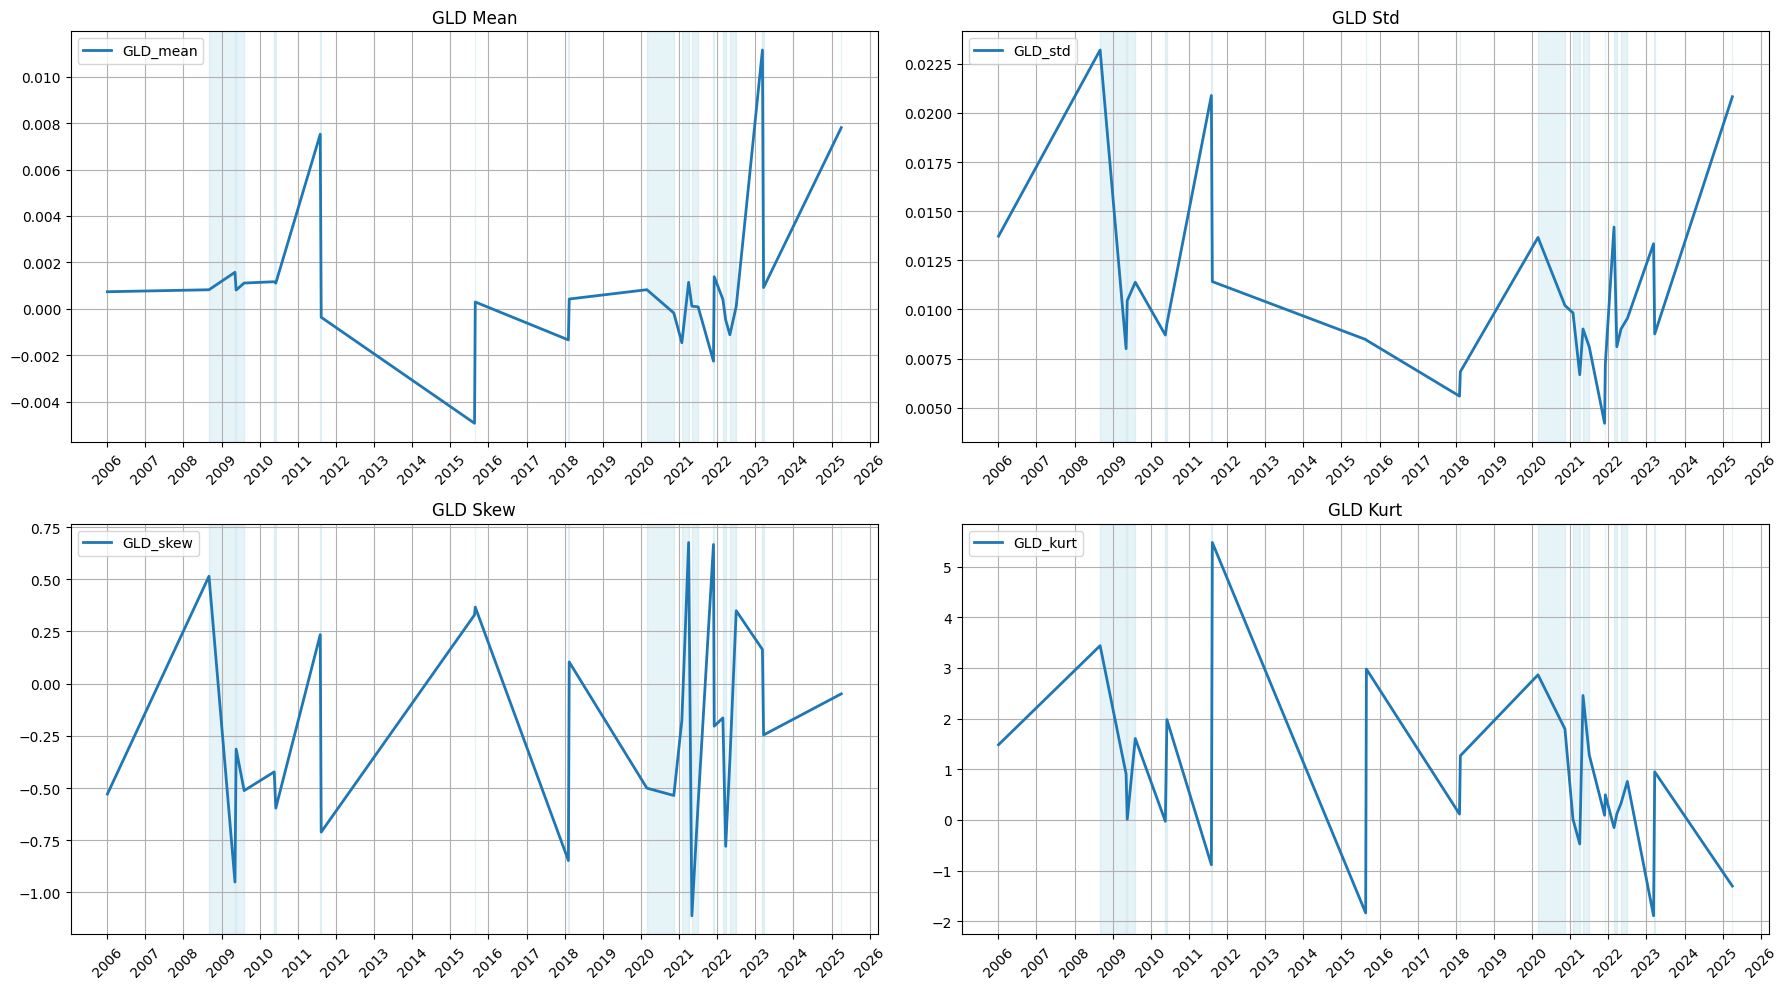

In [ ]:
df_plot = stats_by_period.copy()
df_plot["start_date"] = pd.to_datetime(df_plot["start_date"])

# Métricas a graficar
metrics = ["GLD_mean", "GLD_std", "GLD_skew", "GLD_kurt"]
titles = ["GLD Mean", "GLD Std", "GLD Skew", "GLD Kurt"]

fig, axes = plt.subplots(2, 2, figsize=(18, 10))
axes = axes.flatten()

for ax, metric, title in zip(axes, metrics, titles):

    # Línea principal
    ax.plot(df_plot["start_date"], df_plot[metric], label=metric, linewidth=2)

    # Franjas azules para crisis
    for i, row in df_plot[df_plot["period_type"] == "crisis"].iterrows():
        start = row["start_date"]
        # siguiente periodo o final
        end = df_plot.loc[i + 1, "start_date"] if i + 1 < len(df_plot) else df_plot["start_date"].max()
        ax.axvspan(start, end, color="lightblue", alpha=0.3)

    # Formato del eje X: todos los años
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.tick_params(axis='x', rotation=45)

    ax.set_title(title)
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()



### Fase 3: Cuando la Diversificación Falla (Cópulas)

* Probar que las correlaciones tienen a 1

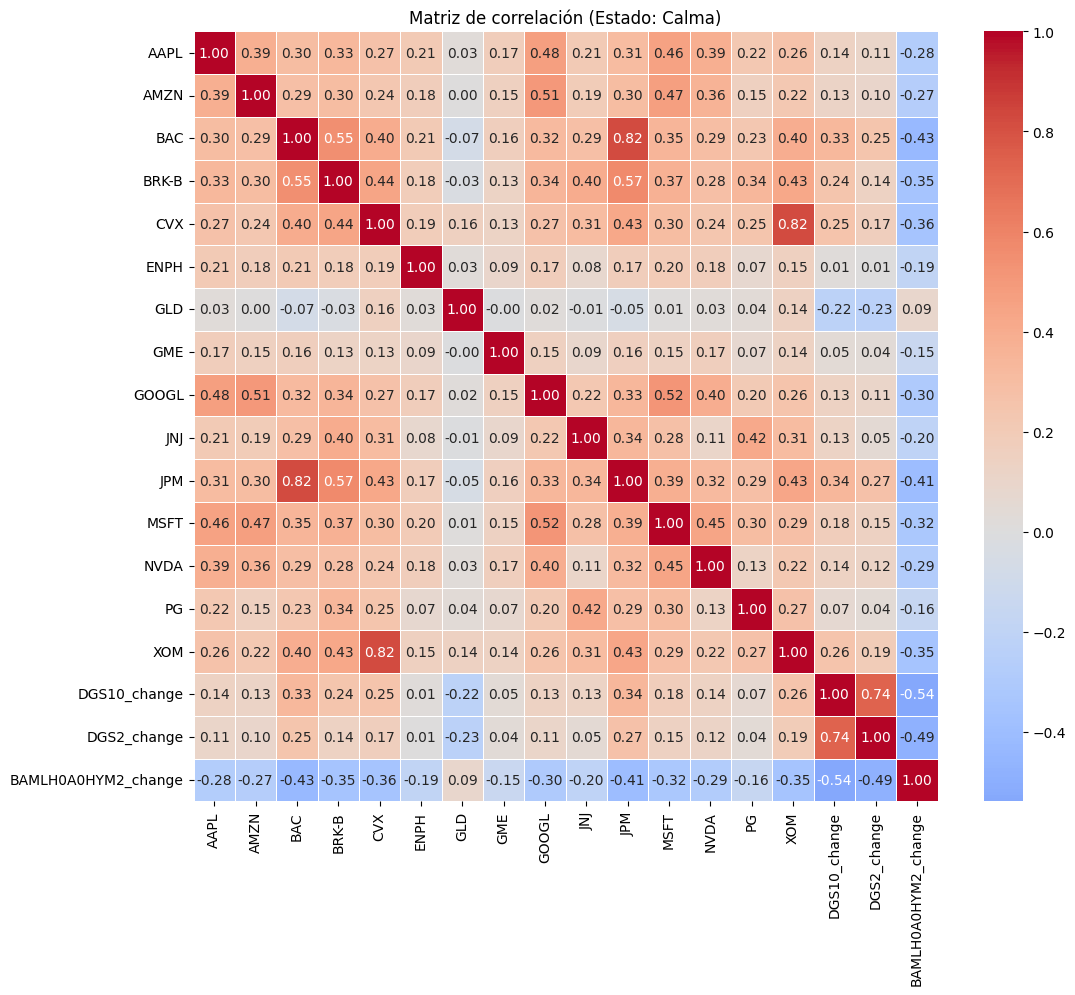

In [210]:
#Calcular matriz de correlación de Pearson en Estado "Calma".

df_calm = df_analysis_periods[df_analysis_periods["period_type"] == "calm"]
df_calm_clean = df_calm.dropna()


numeric_cols = [
    c for c in df_calm.select_dtypes(include="number").columns
    if c not in ["regime", "period_id"]
]
df_calm_numeric = df_calm[numeric_cols]

corr_calm = df_calm_numeric.corr(method="pearson")

plt.figure(figsize=(12, 10))
sns.heatmap(corr_calm, cmap="coolwarm", center=0, annot=True, fmt=".2f", linewidths=0.5)
plt.title("Matriz de correlación (Estado: Calma)")
plt.show()


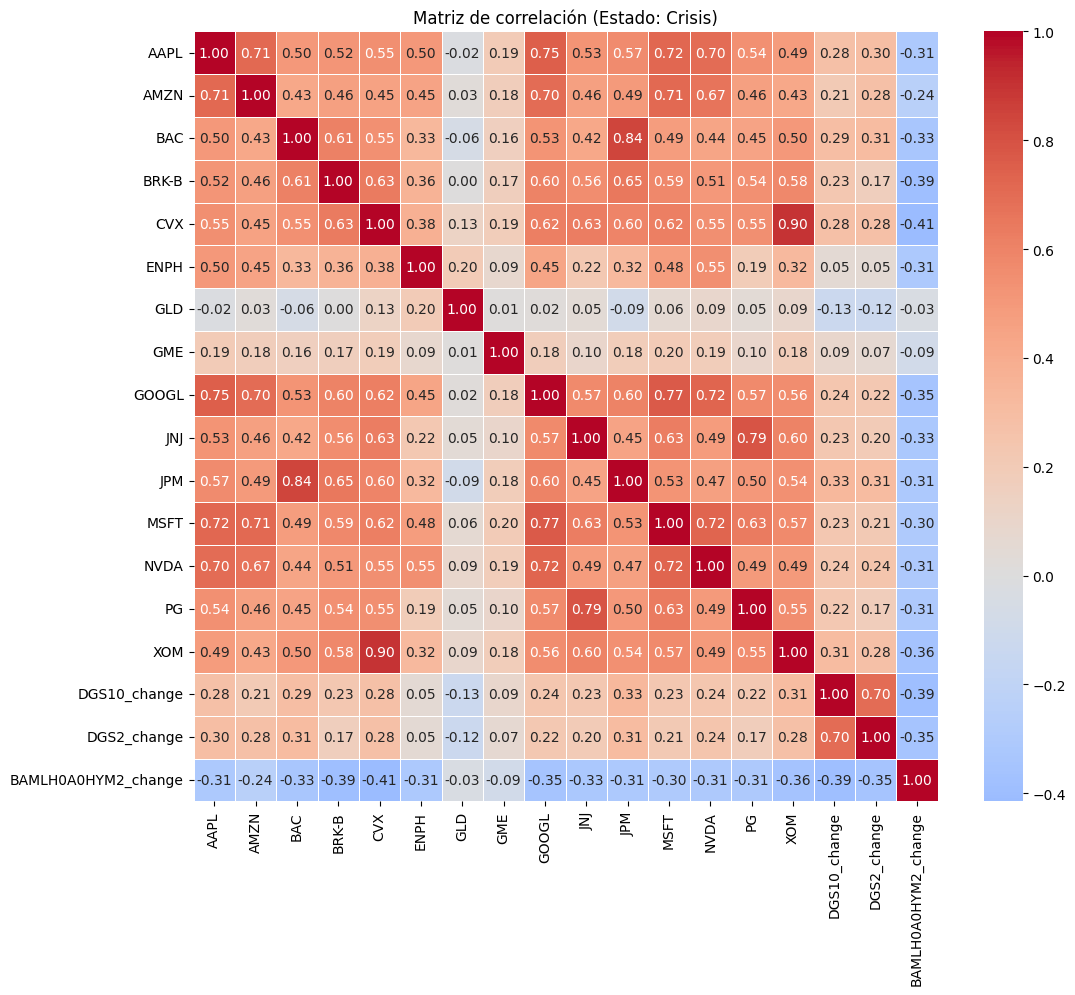

In [ ]:
#Calcular matriz de correlación en Estado "Estrés". 

df_crisis = df_analysis_periods[df_analysis_periods["period_type"] == "crisis"]
df_crisis_clean = df_crisis.dropna()


numeric_cols = [
    c for c in df_crisis.select_dtypes(include="number").columns
    if c not in ["regime", "period_id"]
]
df_crisis_numeric = df_crisis[numeric_cols]

corr_crisis = df_crisis_numeric.corr(method="pearson")

plt.figure(figsize=(12, 10))
sns.heatmap(corr_crisis, cmap="coolwarm", center=0, annot=True, fmt=".2f", linewidths=0.5)
plt.title("Matriz de correlación (Estado: Crisis)")
plt.show()

Se usan las copulas gausianas para periodos de calma y las t-copulas son las más apropiadas para la gestión de riesgos.
Las cópulas no trabajan con retornos directamente, sino con variables transformadas a uniformes. Esta transformación se llama pseudo‑observaciones.


In [221]:
#Ajustar las cópulas en ambos estados.

# Días de calma
df_calm = df_analysis_periods[df_analysis_periods["period_type"] == "calm"]

# Rretornos
numeric_cols = [
    c for c in df_calm.select_dtypes(include="number").columns
    if c not in ["regime", "period_id"]
]

df_calm_numeric = df_calm[numeric_cols].dropna()

# Convertir retornos a pseudo‑observaciones U(0,1)
U_calm = df_calm_numeric.apply(
    lambda x: rankdata(x) / (len(x) + 1), # rankdata Toma una columna de retornos y reemplaza cada valor por su posición ordenada.
                                          # rankdata(x) / (len(x) + 1) Divide cada rango entre el número total de observaciones + 1.          
    axis=0
)                                         #U_calm - Df con cada columna es ahora una variable uniforme U(0,1), la dependencia entre columnas se mantiene
                                          # La forma marginal (la distribución de cada activo) desaparece                      

# Ajustar la cópula gaussiana
copula_calm = GaussianMultivariate()
copula_calm.fit(U_calm)
corr_calm_copula = copula_calm.correlation

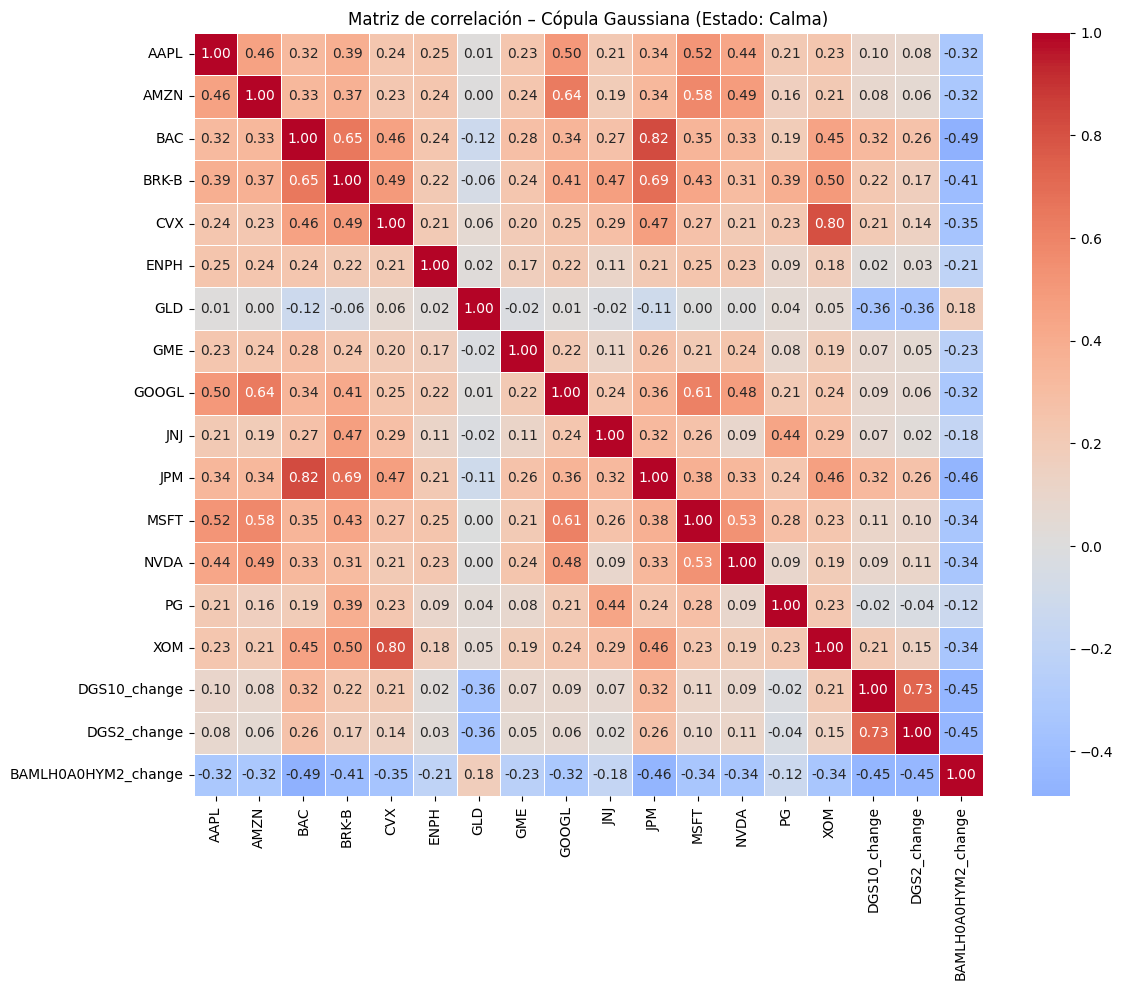

In [223]:
corr_matrix = np.array(corr_calm_copula)

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f",
    xticklabels=numeric_cols,
    yticklabels=numeric_cols,
    linewidths=0.5
)
plt.title("Matriz de correlación – Cópula Gaussiana (Estado: Calma)")
plt.tight_layout()
plt.show()


In [239]:
#Datos sintéticos generados por la cópula
synthetic_calm = copula_calm.sample(len(df_calm_numeric))

# 3 columnas
cols = numeric_cols[:3]   # o elige manualmente 3 columnas

# Comparación 3D
compare_3d(df_calm_numeric, synthetic_calm, columns=cols,
           title="Comparación 3D: Datos Reales vs Cópula Gaussiana (Calma)")


In [ ]:
#Ajustar las cópulas en ambos estados. CRISIS


# Dias crisis
df_crisis = df_analysis_periods[df_analysis_periods["period_type"] == "crisis"]

# Retornos
numeric_cols = [
    c for c in df_crisis.select_dtypes(include="number").columns
    if c not in ["regime", "period_id"]
]

df_crisis_numeric = df_crisis[numeric_cols].dropna()

# 3. Convertir retornos a pseudo‑observaciones U(0,1)
U_crisis = df_crisis_numeric.apply(
    lambda x: rankdata(x) / (len(x) + 1),
    axis=0
)

# 4. Ajustar la t‑cópula
copula_crisis = TCopula()
copula_crisis.fit(U_crisis)

# 5. Obtener la matriz de correlación de la cópula
# En algunas versiones, la matriz está en copula_crisis.correlation
corr_copula_crisis = copula_crisis.correlation

corr_copula_crisis

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_copula_crisis,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f",
    xticklabels=numeric_cols,
    yticklabels=numeric_cols,
    linewidths=0.5
)
plt.title("Matriz de correlación – t‑Cópula (Estado: Crisis)")
plt.tight_layout()
plt.show()
